# MadMiner example

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the ML methods introduced in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020), both by Johann Brehmer, Gilles Louppe, Juan Pavez, and Kyle Cranmer.

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes. Note that at least for now, the MG-Pythia interface and Delphes require custom patches (available upon request). In addition, MadMiner and [DelphesMiner](https://github.com/johannbrehmer/delphesminer) have to be in your PYTHONPATH.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.goldmine import GoldMine
from madminer.tools.plots import plot_2d_morphing_basis

from delphesprocessor.delphesprocessor import DelphesProcessor

from madminer.refinery import combine_and_shuffle
from madminer.refinery import Refinery
from madminer.refinery import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.refinery import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas

from forge.forge import Forge

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [ ]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2'

## 1. Define parameter space

After creating a `GoldMine` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. Finally, the `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

In [ ]:
miner = GoldMine()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-20.,20.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-20.,20.)
)

## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### 2a. Set benchmarks by hand

One can define benchmarks by hand:

In [ ]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':10., 'CPWL2':0.},
    'w'
)
miner.add_benchmark(
    {'CWL2':20., 'CPWL2':0.},
    'w2'
)

### 2b. Benchmarks for morphing

If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points. The argument `n_trials` determines the number of random candidate bases that the optimization algorithm goes through.

In [ ]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

In [ ]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-20.,20),
    yrange=(-20.,20.)
)

## 3. Save settings and run MadGraph

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [ ]:
miner.save('data/madminer_example.h5')

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first. Finally, if MadGraph is supposed to run in a different Python environment or requires other setup steps, you can use the `initial_command` argument.

In [ ]:
miner.run(
    mg_directory=mg_dir,
    proc_card_file='cards/proc_card.dat',
    param_card_template_file='cards/param_card_template.dat',
    reweight_card_template_file='cards/reweight_card_template.dat',
    run_card_file='cards/run_card.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    sample_benchmark='sm',
    initial_command='source activate python2'
)

## 4. Run detector simulation and extract observables

The detector simulation and calculation of observables is not part of MadMiner. The reason is that different users might have very different requirements here: while a phenomenologist might be content with the fast detector simulation from Delphes, an experimental analysis might require the full simulation through Geant4.

We provide the DelphesMiner package, which wraps around Delphes and allows for the fast extraction of observables into the HDF5 file.

Any user is free to replace the DelphesMiner step with a tool of their choice. 

In [2]:
dm = DelphesProcessor(debug=True)

14:29  
14:29  ------------------------------------------------------------
14:29  |                                                          |
14:29  |  DelphesProcessor                                        |
14:29  |                                                          |
14:29  |  Version from July 31, 2018                              |
14:29  |                                                          |
14:29  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
14:29  |                                                          |
14:29  ------------------------------------------------------------
14:29  
14:29  Hi! How are you today?


After creating the DelphesProcessor object, one can add a number of HepMC event samples and have it run Delphes:

In [ ]:
dm.add_hepmc_sample('MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz')

dm.run_delphes(delphes_directory=mg_dir + '/Delphes',
               delphes_card='cards/delphes_card.dat',
               initial_command='source activate python2')

Alternatively (or in addition), the user can provide the path to a Delphes ROOT file (that they processed externally):

In [3]:
dm.add_delphes_sample('MG_process/Events/run_01/tag_1_pythia8_events_delphes.root')

14:29  Adding Delphes sample at MG_process/Events/run_01/tag_1_pythia8_events_delphes.root


The next step is the definition of observables through a name and a python expression. For the latter, you can use the objects `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

There is an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with `np.nan`.

In [4]:
dm.add_observable('pt_j1', 'j[0].pt', required=False)
dm.add_observable('pt_j2', 'j[1].pt', required=False)
dm.add_observable('delta_phi_jj', 'abs(j[0].phi() - j[1].phi())', required=False)
dm.add_observable('delta_eta_jj', 'abs(j[0].eta - j[1].eta)', required=False)
dm.add_observable('m_jj', '(j[0] + j[1]).m', required=False)

14:29  Adding (not required) observable pt_j1 = j[0].pt
14:29  Adding (not required) observable pt_j2 = j[1].pt
14:29  Adding (not required) observable delta_phi_jj = abs(j[0].phi() - j[1].phi())
14:29  Adding (not required) observable delta_eta_jj = abs(j[0].eta - j[1].eta)
14:29  Adding (not required) observable m_jj = (j[0] + j[1]).m


The function `analyse_delphes_samples` extracts all these observables from the Delphes ROOT file(s) generated before:

In [5]:
dm.analyse_delphes_samples()

14:29  Analysing Delphes sample MG_process/Events/run_01/tag_1_pythia8_events_delphes.root


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [6]:
dm.save('data/madminer_example_with_data.h5', 'data/madminer_example.h5')

14:30  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_example_with_data.h5


It's easy to check some (normalized) distributions at this stage

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


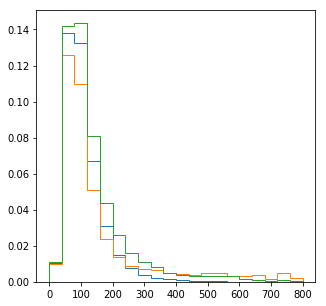

In [10]:
fig = plt.figure(figsize=(5,5))

for weights in dm.weights[:3]:
    plt.hist(dm.observations['pt_j1'], range=(0.,800.), bins=20, histtype='step', weights=weights)

plt.show()

## 5. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In [11]:
combine_and_shuffle(
    ['data/madminer_example_with_data.h5'],
    'data/madminer_example_shuffled.h5'
)

14:30  
14:30  ------------------------------------------------------------
14:30  |                                                          |
14:30  |  MadMiner                                                |
14:30  |                                                          |
14:30  |  Version from July 31, 2018                              |
14:30  |                                                          |
14:30  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
14:30  |                                                          |
14:30  ------------------------------------------------------------
14:30  
14:30  Copying setup from data/madminer_example_with_data.h5 to data/madminer_example_shuffled.h5
14:30  Loading samples from file 1 / 1 at data/madminer_example_with_data.h5


## 6. Make (unweighted) training and test samples

The last important MadMiner class is the `Smithy`. From all the data we have in the HDF5 file now, it extracts unweighted samples including the augmented data ("gold") that is needed as training and evaluation data for the Machine Learning algorithms.

In [12]:
refinery = Refinery('data/madminer_example_shuffled.h5', debug=True)

14:30  
14:30  ------------------------------------------------------------
14:30  |                                                          |
14:30  |  MadMiner                                                |
14:30  |                                                          |
14:30  |  Version from July 31, 2018                              |
14:30  |                                                          |
14:30  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
14:30  |                                                          |
14:30  ------------------------------------------------------------
14:30  
14:30  Loading data from data/madminer_example_shuffled.h5
14:30  Found 2 parameters:
14:30     CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-20.0, 20.0))
14:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-20.0, 20.0))
14:30  Found 6 benchmarks:
14:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:30     w: CWL2 = 10.00, CPWL2 = 0.00e+00


The `Refinery` class defines four different high-level functions to generate train or test samples:
- `extract_samples_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `extract_samples_train_local()` for methods like SALLY and SALLINO;
- `extract_samples_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL; and
- `extract_samples_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`, all defined in the `smithy` module.

In [ ]:
x, theta, t_xz = refinery.extract_samples_train_local(
    theta=constant_morphing_theta(np.array([0.,0.])),
    n_samples=1000,
    folder='./data/samples',
    filename='train_sally'
)

In [ ]:
x, theta0, theta1, y, r_xz, t_xz = refinery.extract_samples_train_ratio(
    theta0=random_morphing_thetas(None, [('flat', -20., 20.), ('flat', -20., 20.)]),
    theta1=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train_rascal'
)

In [ ]:
x, theta = refinery.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='test'
)

Let's have a look at some distributions and correlations in this test sample:

In [ ]:
import corner

labels = [r'$p_{T,j1}$ [GeV]', r'$p_{T,j2}$ [GeV]', r'$\Delta \phi_{jj}$', r'$\Delta \eta_{jj}$', r'$m_{jj}$']
ranges = [(0., 300.), (0., 200.), (0.,6.2), (0.,8.), (0.,1500.)]

_ = corner.corner(x, color='C0', labels=labels, range=ranges)

We can also calculate total cross sections:

In [30]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = refinery.extract_cross_sections(
    theta=multiple_benchmark_thetas(['sm', 'w', 'w2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = refinery.extract_cross_sections(
    theta=random_morphing_thetas(1000, [('flat', -20., 20.), ('flat', -20., 20.)])
)

14:34  theta [0. 0.]: xsec = (0.41109907627105713 +/- 0.0009180789646177098) pb
14:34  theta [10.  0.]: xsec = (0.41811424493789673 +/- 0.006637987310275683) pb
14:34  theta [20.  0.]: xsec = (0.5115107297897339 +/- 0.0032359303657766457) pb
14:34  theta [19.59211262 15.52954843]: xsec = (0.4716585874557495 +/- 0.0016909245363670275) pb
14:34  theta [ -0.28226884 -18.49130942]: xsec = (0.34984999895095825 +/- 0.005551529468019179) pb
14:34  theta [-2.65692076 10.89120855]: xsec = (0.35065943002700806 +/- 0.0014899062199578766) pb
14:34  Total n_samples: 1, n_benchmarks: 1000, n_samples_per_theta: 0
14:34  theta [-19.23316843 -15.22042168]: xsec = (0.6828176779649275 +/- 0.057282765568110135) pb
14:34  theta [  5.46653066 -19.20079678]: xsec = (0.30543877148697895 +/- 0.010302090036020542) pb
14:34  theta [-12.23430531  12.60867812]: xsec = (0.3959055268978049 +/- 0.01956932117828956) pb
14:34  theta [-4.95674096 10.34176829]: xsec = (0.36565196110883136 +/- 0.004385772850876738) pb
14:

14:34  theta [  9.57831252 -14.04392347]: xsec = (0.3515408503807985 +/- 0.009994657485461106) pb
14:34  theta [-13.31351688  19.54074741]: xsec = (0.2942838240731869 +/- 0.017671332771935028) pb
14:34  theta [17.0978304  -3.94230904]: xsec = (0.46220911928261604 +/- 0.00491082908100974) pb
14:34  theta [0.48882647 3.34923562]: xsec = (0.3979081162959487 +/- 0.001574837047215661) pb
14:34  theta [-2.89704569 15.76143498]: xsec = (0.2937299643604373 +/- 0.003661711149536841) pb
14:34  theta [-18.91765111  16.10869807]: xsec = (0.4284534922918819 +/- 0.03815041822796436) pb
14:34  theta [-6.3196597  11.92968407]: xsec = (0.3553946614199599 +/- 0.006121326710336511) pb
14:34  theta [ 0.13625286 16.01812851]: xsec = (0.28875905292838344 +/- 0.006754070035851231) pb
14:34  theta [13.58848205  6.29941239]: xsec = (0.43625940619385317 +/- 0.005713513527792729) pb
14:34  theta [16.98656688 -5.73050945]: xsec = (0.4518198957690551 +/- 0.0056075575422613) pb
14:34  theta [-9.78928657  5.35960904

14:34  theta [ 10.2380212  -13.51679133]: xsec = (0.35711165657495814 +/- 0.009951302412784286) pb
14:34  theta [2.75496292 0.58556007]: xsec = (0.40327315049247997 +/- 0.0033019006272654865) pb
14:34  theta [-10.5134425   -1.21334486]: xsec = (0.5028624192908415 +/- 0.022243281682148903) pb
14:34  theta [13.36223442  9.24191703]: xsec = (0.42260485025208544 +/- 0.00616995329998108) pb
14:34  theta [9.07824283 2.83317297]: xsec = (0.4111253732579415 +/- 0.006700911331753476) pb
14:34  theta [ -7.42193662 -17.96897116]: xsec = (0.4387524402118591 +/- 0.016874457610441) pb
14:34  theta [18.46828277 -5.93414921]: xsec = (0.4655959557449735 +/- 0.005058841695848992) pb
14:34  theta [8.56688138 8.43790317]: xsec = (0.38732254251275183 +/- 0.007550334516611345) pb
14:34  theta [ 9.62322756 -7.90936232]: xsec = (0.39543584040297985 +/- 0.007668204313103125) pb
14:34  theta [-2.00867481 -0.28152685]: xsec = (0.4209378667827705 +/- 0.0032646883408432048) pb
14:34  theta [ 2.02194067 10.94730329

14:34  theta [17.95684135  0.6676904 ]: xsec = (0.486824579769847 +/- 0.0032070255751085065) pb
14:34  theta [-15.02526296  11.72250458]: xsec = (0.44211310257738656 +/- 0.028462547925824838) pb
14:34  theta [15.66372135  0.02538296]: xsec = (0.46044747919690854 +/- 0.004728689874463304) pb
14:34  theta [-2.23500869 14.72860763]: xsec = (0.305996527836483 +/- 0.0035941840673205114) pb
14:34  theta [12.276725    4.54683761]: xsec = (0.4288170044623539 +/- 0.006266332282931698) pb
14:34  theta [10.28308441  0.97650814]: xsec = (0.4195292001893082 +/- 0.00662275019582071) pb
14:34  theta [-5.92112741 -5.40630149]: xsec = (0.46038574413692973 +/- 0.011858580759147383) pb
14:34  theta [ -6.80094735 -10.68301453]: xsec = (0.4652381228395836 +/- 0.014750379721876502) pb
14:34  theta [-17.64763461  17.06808478]: xsec = (0.39212829005418404 +/- 0.03287147954670744) pb
14:34  theta [-4.8056696   5.42122065]: xsec = (0.4084649208568275 +/- 0.006259750472608098) pb
14:34  theta [-18.56568954   9.6

14:34  theta [-11.82944185 -17.42670988]: xsec = (0.5157542975121481 +/- 0.029761444558810222) pb
14:34  theta [ -9.95641589 -13.13883948]: xsec = (0.5024823969154522 +/- 0.02353685436475575) pb
14:34  theta [6.18609887 8.3417237 ]: xsec = (0.3759549055316941 +/- 0.007123017789211197) pb
14:34  theta [-19.26529891   8.44587255]: xsec = (0.5532779954141346 +/- 0.04569237424567981) pb
14:34  theta [6.94530042 6.38031618]: xsec = (0.38972780481621117 +/- 0.006871147590370543) pb
14:34  theta [ 4.08829322 -3.89448595]: xsec = (0.40409113346863407 +/- 0.004166606915667324) pb
14:34  theta [ -1.70137219 -17.45099631]: xsec = (0.3722061484336934 +/- 0.005771228525438534) pb
14:34  theta [ 2.5792734  -3.33242638]: xsec = (0.40707904641794784 +/- 0.0027919417068231257) pb
14:34  theta [-16.57014814  11.14367787]: xsec = (0.4721884865119677 +/- 0.03395467769440624) pb
14:34  theta [ 11.77462192 -11.96548585]: xsec = (0.37431776036118375 +/- 0.009491446024017244) pb
14:34  theta [-5.84496453  0.6

14:34  theta [-18.95108973 -13.45193073]: xsec = (0.6788448206528395 +/- 0.05564752447527405) pb
14:34  theta [10.94627228 -6.80051256]: xsec = (0.4053272658464238 +/- 0.007563954865935419) pb
14:34  theta [  1.69117299 -10.19961754]: xsec = (0.3936073263228319 +/- 0.0028769922380862197) pb
14:34  theta [ 1.65741034 -9.84192121]: xsec = (0.3953435619462079 +/- 0.0027506578340637626) pb
14:34  theta [  2.09775644 -18.93879654]: xsec = (0.32673945849735603 +/- 0.007088405090031114) pb
14:34  theta [ 5.51429478 16.24142995]: xsec = (0.3030817734239254 +/- 0.0100623129454279) pb
14:34  theta [ 0.58505869 -4.97969101]: xsec = (0.4128102501608516 +/- 0.0012705596877718532) pb
14:34  theta [-18.61461922 -14.55294099]: xsec = (0.669308446584261 +/- 0.05452125286899314) pb
14:34  theta [ 17.51293789 -19.64275818]: xsec = (0.31264896811265364 +/- 0.014156268261037589) pb
14:34  theta [-5.34134878 -8.47405932]: xsec = (0.4530117793919366 +/- 0.011074296406117203) pb
14:34  theta [ 8.80268866 -9.6

14:34  theta [-9.56949448  1.99664377]: xsec = (0.4738588167366319 +/- 0.01839412932694118) pb
14:34  theta [-16.96155712   1.29405935]: xsec = (0.5870369344641104 +/- 0.04181212644820989) pb
14:34  theta [-14.62994872  14.31410027]: xsec = (0.3985057960760132 +/- 0.02531602360696435) pb
14:34  theta [-19.57525367  -1.42137241]: xsec = (0.657806705940266 +/- 0.05334502928141001) pb
14:34  theta [ 9.03621733 11.51945877]: xsec = (0.37030007195018644 +/- 0.008350153111841297) pb
14:34  theta [-7.64156693  7.79037411]: xsec = (0.40898311479754623 +/- 0.010985879409460678) pb
14:34  theta [19.39399683  4.77876174]: xsec = (0.5090753638142448 +/- 0.002274308999129645) pb
14:34  theta [ 18.70186821 -14.79679795]: xsec = (0.3865885162402504 +/- 0.009980594927122766) pb
14:34  theta [  6.91373199 -16.06674111]: xsec = (0.33398782109653935 +/- 0.009604512127537192) pb
14:34  theta [11.90182853 12.49411422]: xsec = (0.3879044374806427 +/- 0.007713928694820302) pb
14:34  theta [1.96771884 9.41200

14:34  theta [-11.49450005  15.38086683]: xsec = (0.3477243791396113 +/- 0.015720526861013724) pb
14:34  theta [-19.79024641  -8.31552945]: xsec = (0.6946973428276346 +/- 0.05747325060607727) pb
14:34  theta [ 13.30928233 -18.87053253]: xsec = (0.30452298255623733 +/- 0.013857823664882666) pb
14:34  theta [-8.9562761   7.57965242]: xsec = (0.4224813735550445 +/- 0.014145648664284895) pb
14:34  theta [-12.62570485 -16.53539862]: xsec = (0.5352534064976527 +/- 0.03231661991005305) pb
14:34  theta [  2.90294598 -13.8205165 ]: xsec = (0.36656190400393546 +/- 0.0051881763225690835) pb
14:34  theta [-6.02726012 14.30786523]: xsec = (0.32386887585420726 +/- 0.004571892004585498) pb
14:34  theta [  4.55372519 -11.243273  ]: xsec = (0.3772466861298804 +/- 0.005740744792930628) pb
14:34  theta [  2.6108473  -13.41236756]: xsec = (0.3708495156385082 +/- 0.004757469852954925) pb
14:34  theta [ -5.32901234 -18.08449725]: xsec = (0.40864536585709493 +/- 0.011878876772247486) pb
14:34  theta [ 19.730

14:34  theta [ 6.19497726 16.82210588]: xsec = (0.3003874824263174 +/- 0.010503464030268542) pb
14:34  theta [-18.08944502  17.03314983]: xsec = (0.3991558555027179 +/- 0.034421347796329806) pb
14:34  theta [10.7869644  16.53100413]: xsec = (0.3412552293682245 +/- 0.009665002899938822) pb
14:34  theta [ 9.72591516 18.84431475]: xsec = (0.3049557034078926 +/- 0.011186602973702059) pb
14:34  theta [  2.01834522 -16.26068438]: xsec = (0.35235193898144324 +/- 0.005547111998433835) pb
14:34  theta [-6.72832317 16.78869108]: xsec = (0.2920886646052586 +/- 0.004927063875365054) pb
14:34  theta [14.56400019  5.32820881]: xsec = (0.44849190028920805 +/- 0.005046240289550094) pb
14:34  theta [0.95051941 7.4169305 ]: xsec = (0.3737537392877829 +/- 0.003246033574918528) pb
14:34  theta [13.21460954  5.2933555 ]: xsec = (0.43532992281429916 +/- 0.005868380723444537) pb
14:34  theta [ 0.91520206 14.98828506]: xsec = (0.30223277250937347 +/- 0.006796861948810347) pb
14:34  theta [ -9.06518416 -17.457

14:34  theta [-12.36407592  15.90556941]: xsec = (0.3478979262419499 +/- 0.017651682182276356) pb
14:34  theta [ 4.6279385  11.32415735]: xsec = (0.3482369567358733 +/- 0.007490630388633951) pb
14:34  theta [12.01181629  7.79138905]: xsec = (0.4162003334243631 +/- 0.006687823066340985) pb
14:34  theta [ 11.91193209 -14.0025449 ]: xsec = (0.35633758708544805 +/- 0.010539921745939861) pb
14:34  theta [ 11.74493955 -17.53111679]: xsec = (0.31776118076870086 +/- 0.01266691491103062) pb
14:34  theta [  8.8470674  -13.76607573]: xsec = (0.353582959899463 +/- 0.009560232962532375) pb
14:34  theta [ -3.10100917 -14.7568327 ]: xsec = (0.40565684738509944 +/- 0.00718195977381356) pb
14:34  theta [  3.14102871 -15.61127813]: xsec = (0.3514562148696251 +/- 0.006213101456858021) pb
14:34  theta [3.75168707 5.73397997]: xsec = (0.3845169373727928 +/- 0.005159877560912753) pb
14:34  theta [18.81537733 -1.84038975]: xsec = (0.4901198415050539 +/- 0.0035371263627601165) pb
14:34  theta [ 3.253748   -2.

14:34  theta [ -4.90109459 -16.93862944]: xsec = (0.41164632860173267 +/- 0.010871567713051837) pb
14:34  theta [-6.27934137 -6.46613993]: xsec = (0.46448504085122233 +/- 0.012877198847081653) pb
14:34  theta [-15.63032739  18.06137075]: xsec = (0.34723335501191066 +/- 0.02549255190433186) pb
14:34  theta [-15.27335388   9.66643854]: xsec = (0.4731941017913239 +/- 0.03072355707856045) pb
14:34  theta [-9.54989677 10.41158983]: xsec = (0.39743780620475166 +/- 0.013989432543121785) pb
14:34  theta [-12.07509988 -15.73468524]: xsec = (0.5286371604360074 +/- 0.030406815499482157) pb
14:34  theta [12.65587382 -7.36817237]: xsec = (0.4103384875439915 +/- 0.007655900718824103) pb
14:34  theta [-11.1103739   -1.51336424]: xsec = (0.5121754993822104 +/- 0.024053915363268848) pb
14:34  theta [-2.74553207 -0.98959287]: xsec = (0.4271743714824174 +/- 0.004629431770696019) pb
14:34  theta [-12.14265783  -6.92895849]: xsec = (0.5432318232992184 +/- 0.02895011844991694) pb
14:34  theta [-0.6377484 12

14:34  theta [-4.36683085 18.86931071]: xsec = (0.25142206316221183 +/- 0.004708989635292575) pb
14:34  theta [  9.16515853 -14.9388613 ]: xsec = (0.3429440565903808 +/- 0.010285163374843254) pb
14:34  theta [ 16.98765626 -12.37800986]: xsec = (0.39934098943651164 +/- 0.008917003836738198) pb
14:34  theta [-0.5262825  -3.78098231]: xsec = (0.4185043159004176 +/- 0.001822977591562929) pb
14:34  theta [17.73442539 12.12528094]: xsec = (0.46316036150966333 +/- 0.0025641415397117734) pb
14:34  theta [-19.22766629 -14.99217121]: xsec = (0.6831483557725945 +/- 0.05720507505762516) pb
14:34  theta [ 5.97004275 -3.08246718]: xsec = (0.4045839386771956 +/- 0.005499724598380881) pb
14:34  theta [17.98233281  5.33905215]: xsec = (0.4890693569766906 +/- 0.00242113477920495) pb
14:34  theta [ 13.43777595 -17.85714072]: xsec = (0.3179862676624633 +/- 0.013117588574127956) pb
14:34  theta [  6.7171575  -13.01990292]: xsec = (0.36077349699224914 +/- 0.008040861039678637) pb
14:34  theta [ -9.02020674 

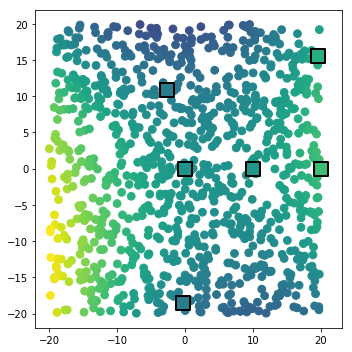

In [35]:
fig = plt.figure(figsize=(5,5))

plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=60., cmap='viridis', vmin=0.1, vmax=.7,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=0.1, vmax=.7, lw=2., edgecolor='black',
            marker='s')

plt.tight_layout()
plt.show()

For debugging, you can also access the full list of observables and benchmark weights (same units as in the LHE file) in the HDF5 file:

In [ ]:
all_x, all_weights = refinery.extract_raw_data(theta=[0.0,0.1])

print(all_x)
print(all_weights)

## 7. Train likelihood ratio estimator

It's now time to build the likelihood ratio estimators. The central object for this is the `Forge` class. It defines functions that train, save, load, and evaluate the neural networks that estimate the likelihood ratio.

Here we will use the RASCAL method described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). Other soon-to-be implemented methods include CARL, CASCAL, and ROLR described in the same publications, as well as ALICE and ALICES which are introduced in a paper that will soon hit the arXiv. SALLY and SALLINO will follow at some point.

In [ ]:
forge = Forge(debug=True)

forge.train(
    method='rolr',
    theta_filename='data/samples/theta0_train_rascal.npy',
    x_filename='data/samples/x_train_rascal.npy',
    y_filename='data/samples/y_train_rascal.npy',
    r_xz_filename='data/samples/r_xz_train_rascal.npy',
    t_xz_filename='data/samples/t_xz_train_rascal.npy',
    alpha=100.,
    n_epochs=50,
    validation_split=0.2
)

forge.save('models/rascal')

`forge.evaluate(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood and 25\*100 estimates for the  score, both indexed by `[i_theta,i_x]`.

In [ ]:
theta_each = np.linspace(-100.,100.,11)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/theta_grid.npy', theta_grid)


In [ ]:
forge.load('models/rascal')

log_r_hat, t_hat = forge.evaluate(
    theta_filename='data/theta_grid.npy',
    x_filename='data/samples/x_test.npy',
)

In [ ]:
expected_llr = np.mean(log_r_hat, axis=1)

fig = plt.figure(figsize=(5,5))

plt.scatter(theta_grid[:,0], theta_grid[:,1], c=expected_llr,
            s=150., cmap='viridis',
            marker='s')

plt.tight_layout()
plt.show()